Data exploration and analysis
================================

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from datetime import datetime
from pandas import Series
from math import ceil

In [2]:
df = pd.read_csv('xceldata.csv', encoding="utf-8")
dfa = df
dfa = dfa.copy()
df[:5]

,Name,Year_of_Release,Genre,Publisher,Critic_Score,ESRB_Rating,Global_Sale
0,Monster Hunter Rise,2022.0,Card Game,Capcom,88.0,M,11.200000
1,The Anacrusis,2022.0,Shooter,Stray Bombay Company,51.0,T,0.200000
2,God of War,2022.0,Action,PlayStation PC,94.0,M,60.000128
3,Rainbow Six Extraction,2022.0,Action,Ubisoft,71.0,M,9.000000
4,Windjammers 2,2022.0,Sports,DotEmu,78.0,E,0.040688


In [3]:
df.isnull().sum()

Name                  0
Year_of_Release       8
Genre                 0
Publisher             1
Critic_Score       9054
ESRB_Rating        7138
Global_Sale           0
dtype: int64

In [4]:
df = df.dropna(axis=0)
df.isnull().sum()

Name               0
Year_of_Release    0
Genre              0
Publisher          0
Critic_Score       0
ESRB_Rating        0
Global_Sale        0
dtype: int64

Top values in the dataset
---
**By platform, developer, publisher and genre.**

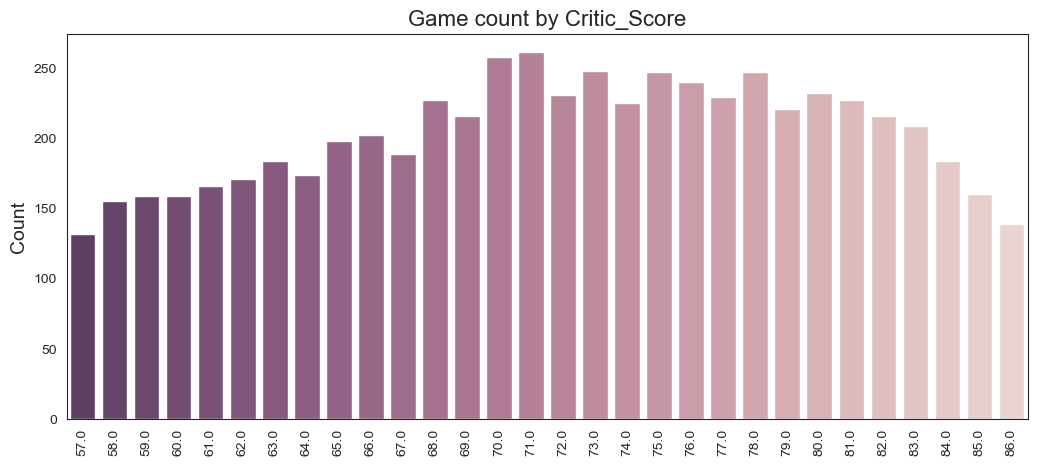

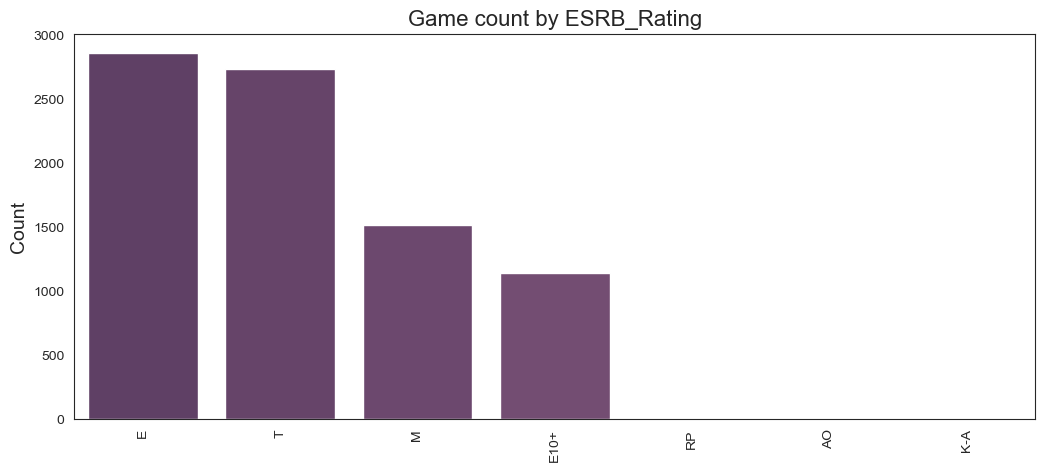

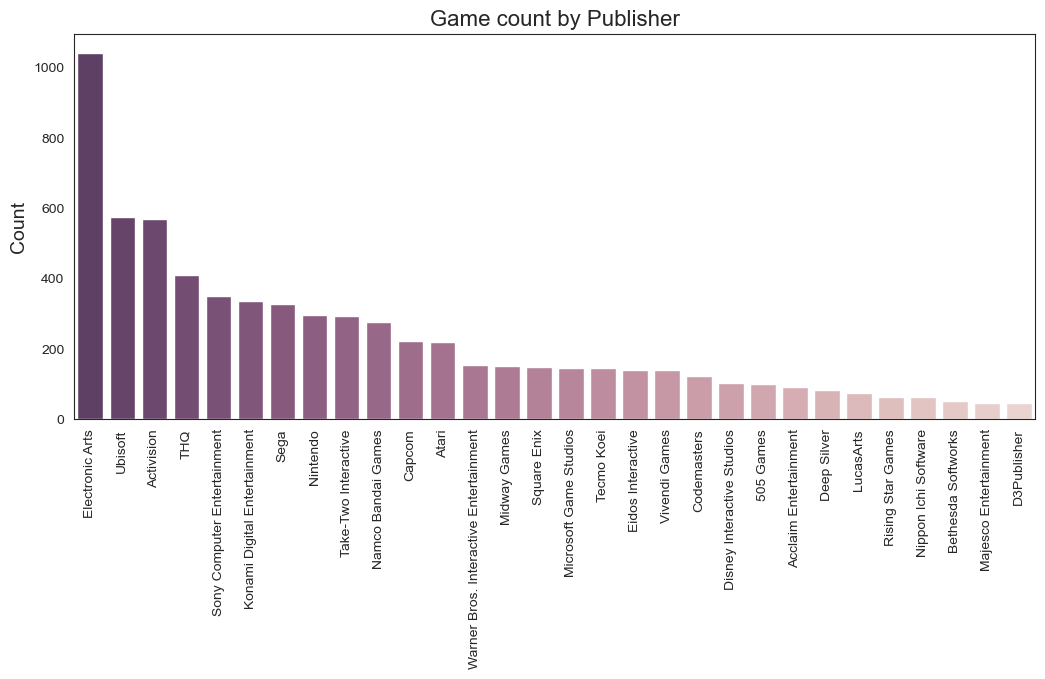

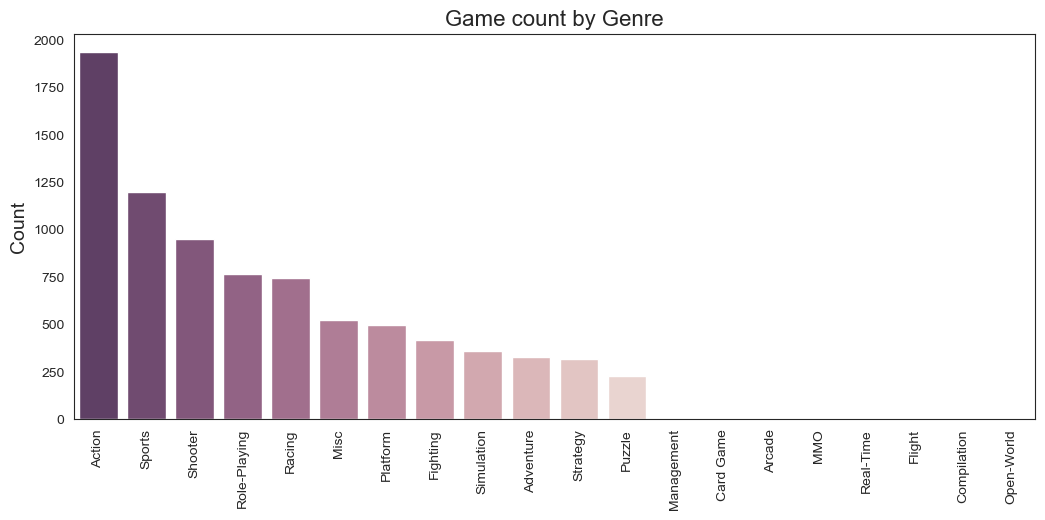

In [5]:
cols = ['Critic_Score', 'ESRB_Rating', 'Publisher', 'Genre']

for col in cols:
    chart = df[['Name', col]].groupby([col]).count().sort_values('Name', ascending=False).reset_index()
    sns.set_style("white")
    plt.figure(figsize=(12.4, 5))
    plt.xticks(rotation=90)
    sns.barplot(x=col, y='Name', data=chart[:30], palette=sns.cubehelix_palette((12 if col == 'Genre' else 30), dark=0.3, light=.85, reverse=True)).set_title(('Game count by '+col), fontsize=16)
    plt.ylabel('Count', fontsize=14)
    plt.xlabel('')

Sales vs. critic scores
--------------------------------
**By platform, developer, publisher, and genre.**

In [6]:
def score_group(score):
    if score >= 90:
        return '90-100'
    elif score >= 80:
        return '80-89'
    elif score >= 70:
        return '70-79'
    elif score >= 60:
        return '60-69'
    elif score >= 50:
        return '50-59'
    else:
        return '0-49'

In [7]:
dfh = df.dropna(subset=['Critic_Score']).reset_index(drop=True)
dfh['Score_Group'] = dfh['Critic_Score'].apply(lambda x: score_group(x))

In [8]:
def in_top(x):
    if x in pack:
        return x
    else:
        pass
def width(x):
    if x == 'Critic_Score':
        return 14.4
    elif x == 'ESRB_Rating':
        return 13.2
    elif x == 'Publisher':
        return 11.3
    elif x == 'Genre':
        return 13.6

def height(x):
    if x == 'Genre':
        return 8
    else:
        return 9

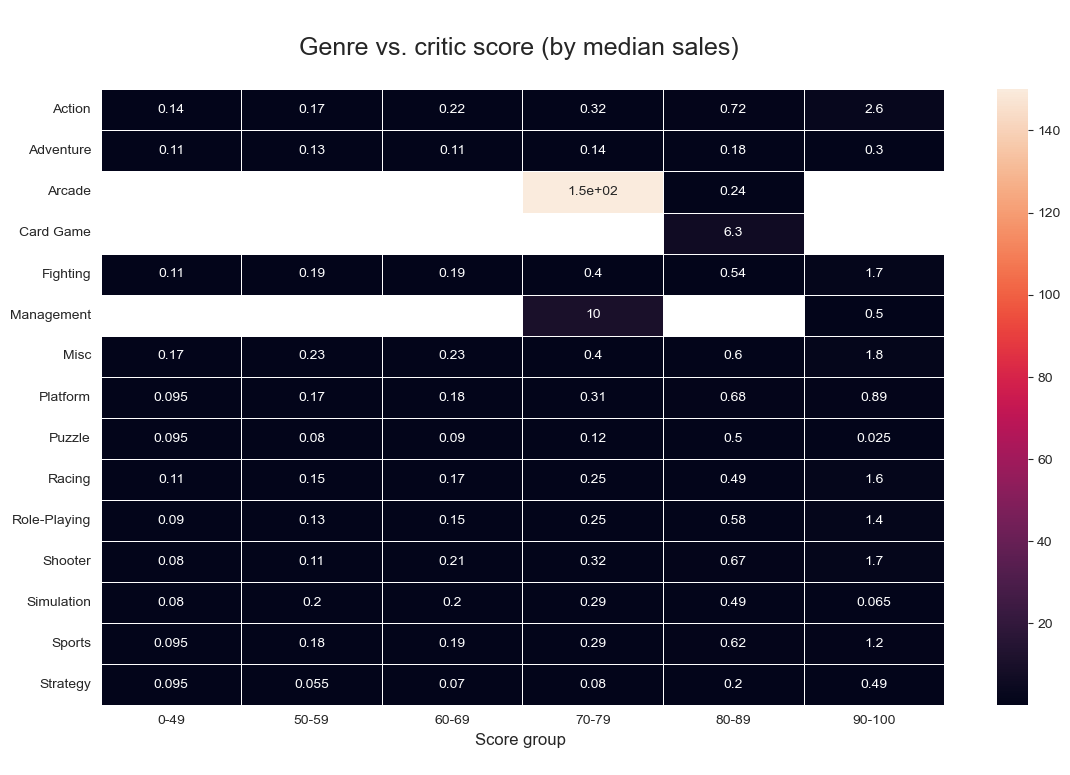

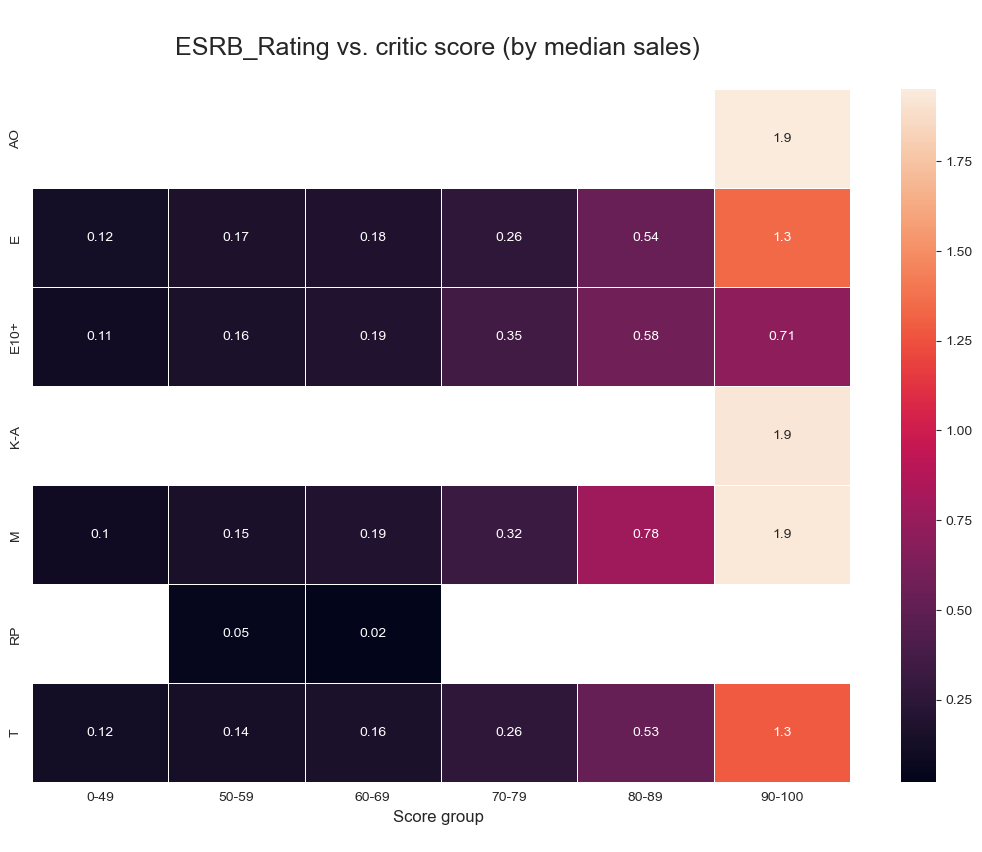

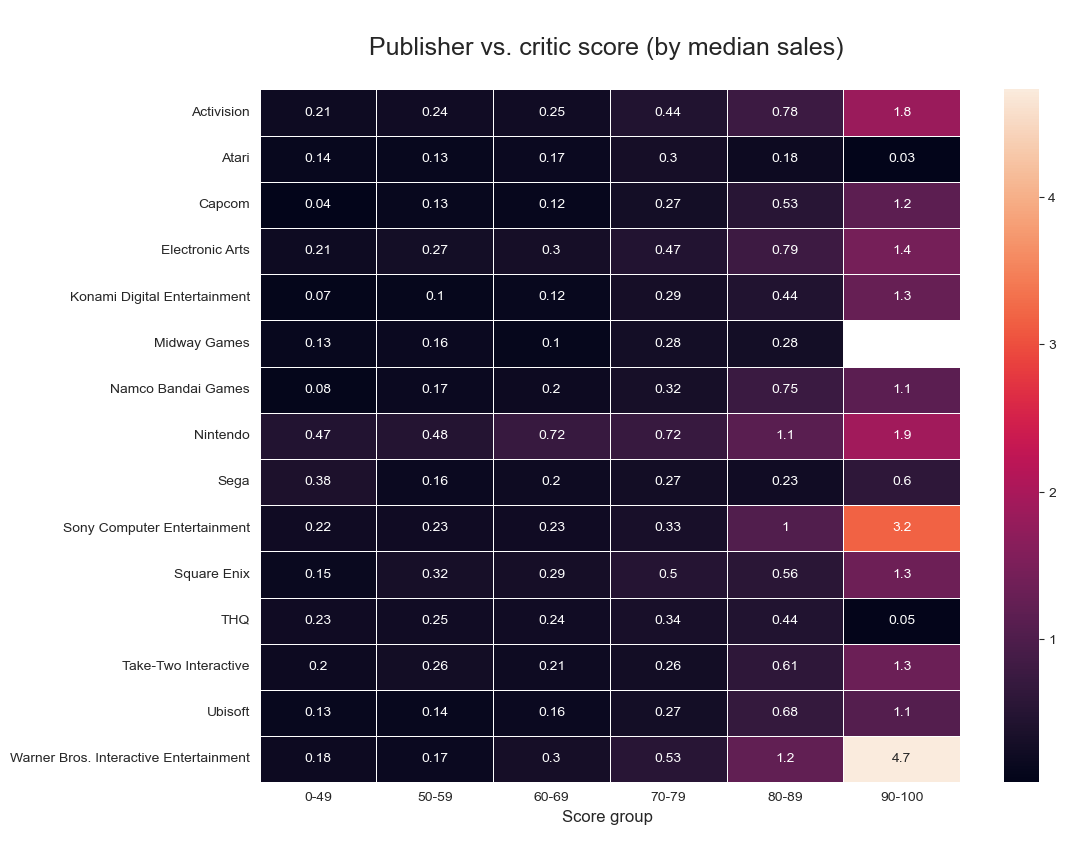

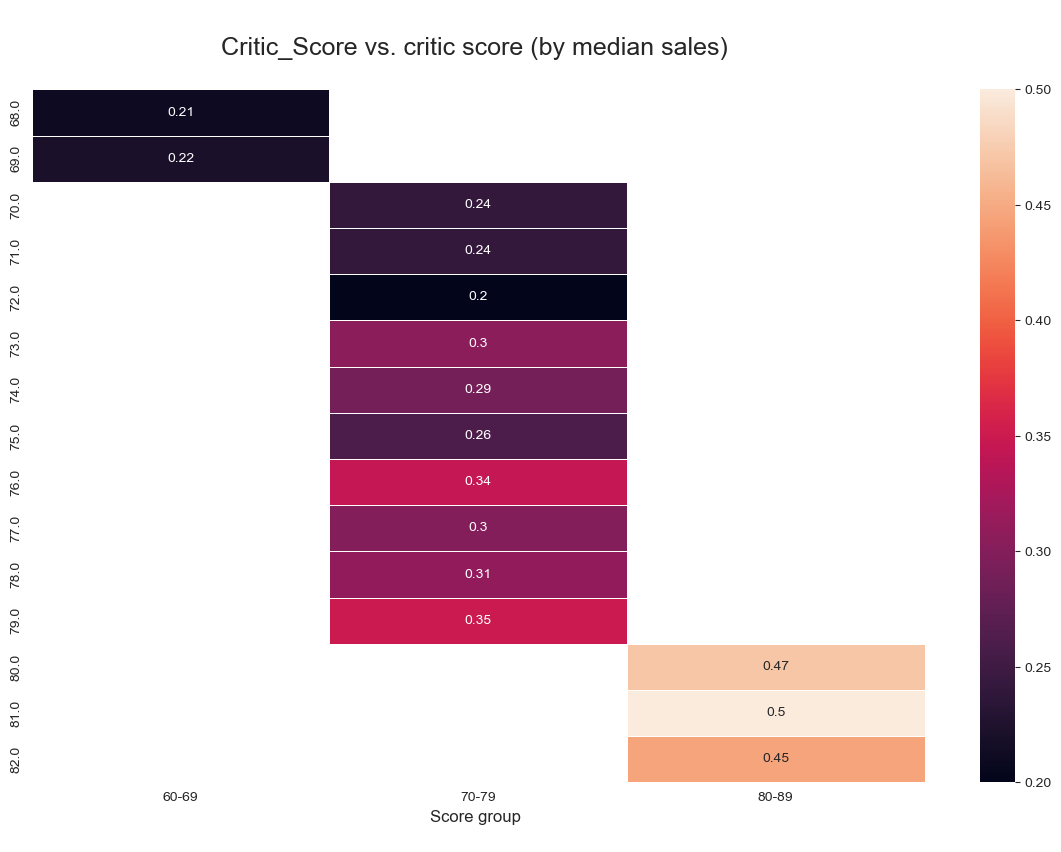

In [9]:
cols = ['Genre', 'ESRB_Rating', 'Publisher', 'Critic_Score']
for col in cols:
    pack = []
    top = dfh[['Name', col]].groupby([col]).count().sort_values('Name', ascending=False).reset_index()[:15]
    for x in top[col]:
        pack.append(x)
    dfh[col] = dfh[col].apply(lambda x: in_top(x))
    dfh_platform = dfh[[col, 'Score_Group', 'Global_Sale']].groupby([col, 'Score_Group']).median().reset_index().pivot(col, "Score_Group", "Global_Sale")
    plt.figure(figsize=(width(col), height(col)))
    sns.heatmap(dfh_platform, annot=True, fmt=".2g", linewidths=.5).set_title((' \n'+col+' vs. critic score (by median sales) \n'), fontsize=18)
    plt.ylabel('', fontsize=14)
    plt.xlabel('Score group \n', fontsize=12)
    pack = []

Dataset correlations
--------------------------------
**Conversion of categorical columns into numeric codes**

In [10]:
cols = ['Critic_Score', 'Genre', 'Publisher', 'ESRB_Rating']
for col in cols:
    uniques = df[col].value_counts().keys()
    uniques_dict = {}
    ct = 0
    for i in uniques:
        uniques_dict[i] = ct
        ct += 1

    for k, v in uniques_dict.items():
        df.loc[df[col] == k, col] = v

In [11]:
df1 = df[['Critic_Score', 'Genre', 'Publisher','Year_of_Release', 'ESRB_Rating','Global_Sale']]
df1 = df1.dropna().reset_index(drop=True)
df1 = df1.astype('float64')

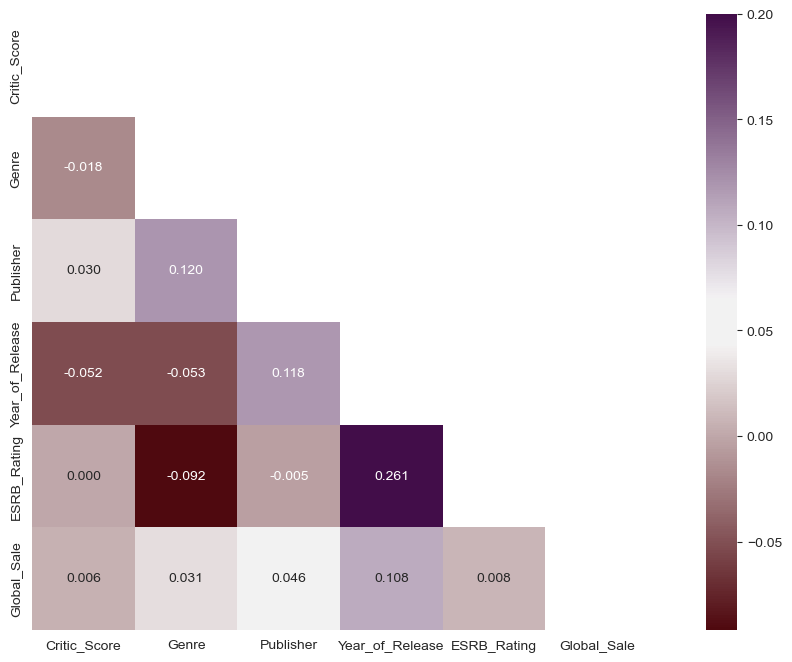

In [12]:
mask = np.zeros_like(df1.corr())
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(730, 300, sep=20, as_cmap=True, s=85, l=15, n=20) # note: 680, 350/470
with sns.axes_style("white"):
    fig, ax = plt.subplots(1,1, figsize=(15,8))
    ax = sns.heatmap(df1.corr(), mask=mask, vmax=0.2, square=True, annot=True, fmt=".3f", cmap=cmap)

**Strongest correlations are:**

 

 - ***Critic scores-to-global sales*:  We'll take a closer look at this below.**
 
 - ***Year of release-to-platform*:  This makes sense since new platforms come out periodically.**

Critic scores to global sales
-----------------------------

[(0.0, 17.5)]

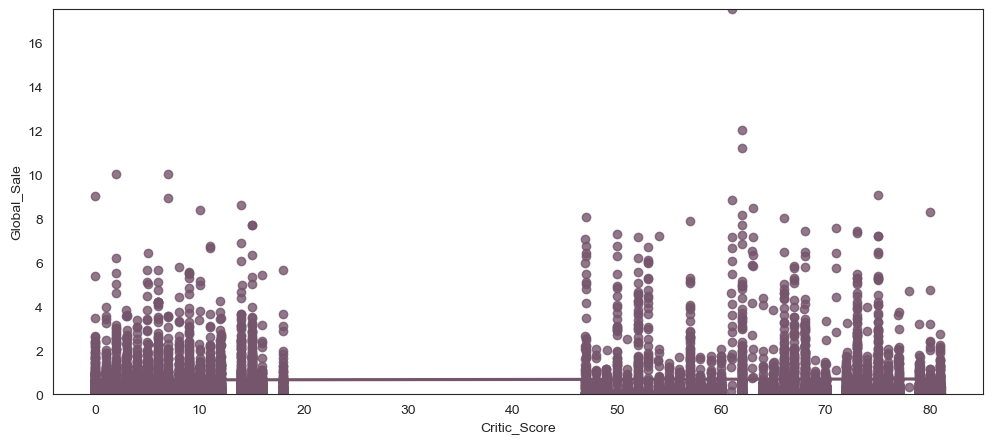

In [13]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
sns.regplot(x="Critic_Score", y="Global_Sale", data=df1, ci=None, color="#75556c", x_jitter=.02).set(ylim=(0, 17.5))

**Kinda messy, right?**

**We'll go ahead and use bins to get a better feel for the correlation.**

[(0.0, 4.0), (50.0, 95.0)]

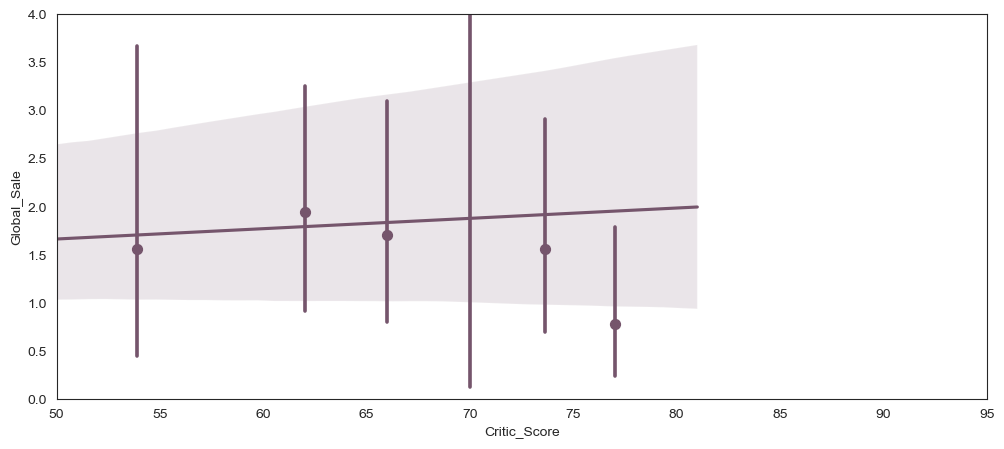

In [15]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
sns.regplot(x="Critic_Score", y="Global_Sale", data=df1.loc[df1.Year_of_Release >= 2014],
            truncate=True, x_bins=15, color="#75556c").set(ylim=(0, 4), xlim=(50, 95))

**The relationship looks much clearer now. It's interesting how the slope gets steeper in the 80's. It seems once a game gets a high critic score, every additional point has a higher impact. Go big or go home, right?** 

**Looks like critic scores will be a good feature for the prediction model in section 2.**

Defining *hits* as those with sales above 1 million units
---------------------------------------------------------
**This will be the target in our prediction model, where we'll predict if a game will be a hit or not.**

In [16]:
dfb = dfa[['Name','ESRB_Rating','Genre','Publisher','Year_of_Release','Critic_Score','Global_Sale']]
dfb = dfb.dropna().reset_index(drop=True)
df2 = dfb[['ESRB_Rating','Genre','Publisher','Year_of_Release','Critic_Score','Global_Sale']]
df2['Hit'] = df2['Global_Sale']
df2.drop('Global_Sale', axis=1, inplace=True)

In [17]:
def hit(sales):
    if sales >= 1:
        return 1
    else:
        return 0

df2['Hit'] = df2['Hit'].apply(lambda x: hit(x))

**Let's graph the relationship between critic scores and VG hits using a 5% sample...** 

<AxesSubplot:xlabel='Critic_Score', ylabel='Hit'>

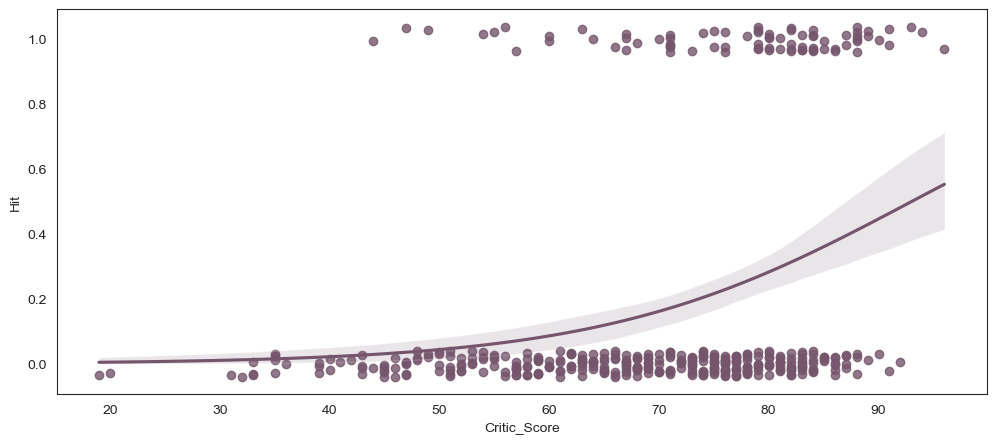

In [18]:
# Logistic regression plot with sample of the data
n = ceil(0.05 * len(df2['Hit']))
fig, ax = plt.subplots(1,1, figsize=(12,5))
sns.regplot(x="Critic_Score", y="Hit", data=df2.sample(n=n),
            logistic=True, n_boot=500, y_jitter=.04, color="#75556c")

**As expected, it seems hits are mostly found near high critic scores, while non-hits can vary in scores but don't have as strong of a presence in the high score ranges (as seen in the steepening regression curve near the 70's).**

----------

2. Prediction model
=============================
**For predicting VGs with unit sales of 1 million or higher (hits).**

In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn import svm

Generating features
------------------------------------------------------------------------

In [20]:
df2[:5]

,ESRB_Rating,Genre,Publisher,Year_of_Release,Critic_Score,Hit
0,M,Card Game,Capcom,2022.0,88.0,1
1,T,Shooter,Stray Bombay Company,2022.0,51.0,0
2,M,Action,PlayStation PC,2022.0,94.0,1
3,M,Action,Ubisoft,2022.0,71.0,1
4,E,Sports,DotEmu,2022.0,78.0,0


In [21]:
from pandas import get_dummies
df_copy = pd.get_dummies(df2)

In [22]:
df_copy[:5]

,Year_of_Release,Critic_Score,Hit,ESRB_Rating_AO,ESRB_Rating_E,ESRB_Rating_E10+,ESRB_Rating_K-A,ESRB_Rating_M,ESRB_Rating_RP,ESRB_Rating_T,...,Publisher_Yacht Club Games,Publisher_YooStar Entertainment Group Inc.,Publisher_Yukes,Publisher_Zoo Digital Publishing,Publisher_Zoo Games,Publisher_Zushi Games,Publisher_bitComposer Games,Publisher_id Software,Publisher_inXile Entertainment,Publisher_tinyBuild
0,2022.0,88.0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022.0,51.0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2022.0,94.0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022.0,71.0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022.0,78.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
df3 = df_copy
y = df3['Hit'].values
df3 = df3.drop(['Hit'],axis=1)
X = df3.values

In [24]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.50, random_state=2)

Testing prediction accuracy with LR and RFC
-------------------------------------------

In [25]:
radm = RandomForestClassifier(random_state=2).fit(Xtrain, ytrain)
y_val_1 = radm.predict_proba(Xtest)
print("Validation accuracy: ", sum(pd.DataFrame(y_val_1).idxmax(axis=1).values
                                   == ytest)/len(ytest))

Validation accuracy:  0.8374062424389064


In [26]:
log_reg = LogisticRegression(max_iter=3000).fit(Xtrain, ytrain)
y_val_2 = log_reg.predict_proba(Xtest)
print("Validation accuracy: ", sum(pd.DataFrame(y_val_2).idxmax(axis=1).values==ytest)/len(ytest))

Validation accuracy:  0.8434551173481732


In [27]:
all_predictions = log_reg.predict(Xtest)
print(classification_report(ytest, all_predictions))

              precision    recall  f1-score   support

           0       0.85      0.98      0.91      3435
           1       0.64      0.16      0.26       698

    accuracy                           0.84      4133
   macro avg       0.75      0.57      0.59      4133
weighted avg       0.82      0.84      0.80      4133



Text(0.5, 1.0, 'Training Set Confusion Matrix')

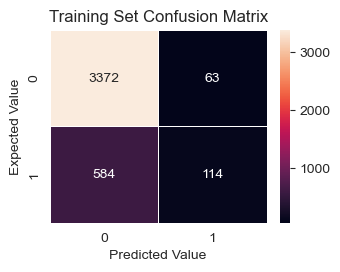

In [28]:
fig, ax = plt.subplots(figsize=(3.5,2.5))
sns.heatmap(confusion_matrix(ytest, all_predictions), annot=True, linewidths=.5, ax=ax, fmt="d").set(xlabel='Predicted Value', ylabel='Expected Value')
plt.title('Training Set Confusion Matrix')